# Stochastic analysis of different block libraries
Purpose of this notebook is to compute a number of different measures that allow us to assess different block libraries and the towers that get generated for them.

This can be seen a an attempt of providing algorithm-independent measures of tower complexity.

In [1]:
# set up imports
import os
import sys
__file__ = os.getcwd()
proj_dir =  os.path.dirname(os.path.realpath(__file__))
sys.path.append(proj_dir)
utils_dir = os.path.join(proj_dir,'utils')
sys.path.append(utils_dir)
analysis_dir = os.path.join(proj_dir,'analysis')
analysis_utils_dir = os.path.join(analysis_dir,'utils')
sys.path.append(analysis_utils_dir)
agent_dir = os.path.join(proj_dir,'model')
sys.path.append(agent_dir)
agent_util_dir = os.path.join(agent_dir,'utils')
sys.path.append(agent_util_dir)
experiments_dir = os.path.join(proj_dir,'experiments')
sys.path.append(experiments_dir)
df_dir = os.path.join(proj_dir,'results/dataframes')
stim_dir = os.path.join(proj_dir,'stimuli')

In [2]:
import tqdm

import pickle

import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy

from IPython.display import clear_output

import utils.blockworld_library as bl
import utils.blockworld as bw
from utils.blockworld import *
import stimuli.tower_generator as tower_generator

from model.Random_Agent import Random_Agent
from model.stochastic_tower_analysis import *

pygame 2.1.0 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# create sets of worlds
sets = {}

In [4]:
# just use a random agent here
agent = Random_Agent()

Load in towers:

In [5]:
# load in towers for bl_nonoverlapping_simple
set_ = 'bl_nonoverlapping_simple'
PATH_TO_TOWERS = os.path.join(
    stim_dir, 'generated_towers_bl_nonoverlapping_simple.pkl')
# load towers
with open(PATH_TO_TOWERS, 'rb') as f:
    towers = pickle.load(f)
for i in range(len(towers)):
    towers[i]['name'] = str(i)
towers = {t['name']: t['bitmap'] for t in towers}
worlds = {name: bw.Blockworld(silhouette=silhouette, block_library=bl.bl_nonoverlapping_simple,
                              legal_action_space=True, physics=True) for name, silhouette in towers.items()}
sets[set_] = worlds

In [6]:
# load in towers for bl_silhouette2_default
set_ = 'bl_silhouette2_default'
worlds = {'int_struct_'+str(i): bw.Blockworld(silhouette=bl.load_interesting_structure(
    i), block_library=bl.bl_silhouette2_default, legal_action_space=True, physics=True) for i in range(1,16+1)}
sets[set_] = worlds

**OR** alternatively create the towers from scratch:

In [7]:
NUM_TOWERS = 128
block_libraries = {"bl_nonoverlapping_simple": bl.bl_nonoverlapping_simple, "bl_nonoverlapping_med": bl.bl_nonoverlapping_med, "bl_silhouette2_default": bl.bl_silhouette2_default}

Tower_Generator= tower_generator.TowerGenerator(8, 8,
                                   block_library=bl.bl_nonoverlapping_simple,
                                   padding=(2, 0),
                                   num_blocks=6,
                                   )

In [8]:
sets = {}

for set_,block_library in block_libraries.items():
    # create a number of random towers
    sets[set_] = {}
    for i in tqdm(range(NUM_TOWERS)):
        tower = Tower_Generator.generate()
        world = bw.Blockworld(silhouette=tower['bitmap'], block_library=block_library,)
        sets[set_][set_+"_"+str(i)] = world
    

100%|██████████| 128/128 [00:00<00:00, 129.01it/s]


---

In [9]:
N = 4092

Let's run it. This can be slow, and jupyter notebook can be time out. Therefore, we'll pickle the inputs, run it offline and then load the result back in. 

In [10]:
location = prep_for_offline_running(sets, agent, N)
print("\n Run `python model/stochastic_tower_analysis.py {}` from the repo directory to run the analysis".format(location.split('/')[-1]))

Saved to /Users/felixbinder/Cloud/Grad School/Fan Lab/Block Construction/tools_block_construction/results/dataframes/bl_nonoverlapping_simple_bl_nonoverlapping_med_bl_silhouette2_default_Random_Agent_stochastic_tower_analysis.pkl

 Run `python model/stochastic_tower_analysis.py bl_nonoverlapping_simple_bl_nonoverlapping_med_bl_silhouette2_default_Random_Agent_stochastic_tower_analysis.pkl` from the repo directory to run the analysis


Read the output back in:

In [13]:
df = pd.read_pickle(location)
print("Read in dataframe with {} rows".format(len(df)))

Read in dataframe with 384 rows


Alternatively, we can run it in the notebook and hope that it's fast enough.

In [12]:
df = pd.DataFrame(columns=['set', 'tower', 'outcome_ratio', 'avg_branching_factor', 'branching_factors', 'outcomes'])

# run the analysis
for set_ in sets:
    worlds = sets[set_]
    for i, world_name in enumerate(worlds.keys()):
        print('Set {} -> Analyzing world {} of {}: {}'.format(set_, i, len(worlds), world_name))
        world = worlds[world_name]
        outcome_ratio, total_branching_factor, branching_factors, outcomes = analyze_single_tower(world, agent, n = N)
        # save the results
        df = df.append({'set': set_, 'tower': world_name, 'outcome_ratio': outcome_ratio, 'avg_branching_factor': total_branching_factor, 'branching_factors': branching_factors, 'outcomes': outcomes}, ignore_index=True)
        clear_output()


Set bl_nonoverlapping_simple -> Analyzing world 0 of 128: bl_nonoverlapping_simple_0


  1%|▏         | 56/4092 [00:05<06:16, 10.72it/s]


KeyboardInterrupt: 

---
## Analysis

How many random paths end in success?

set
bl_nonoverlapping_med       0.0
bl_nonoverlapping_simple    0.0
bl_silhouette2_default      0.0
Name: outcome_ratio, dtype: float64

<AxesSubplot:title={'center':'Ratio of winning leaf nodes to all leaf nodes'}, xlabel='set'>

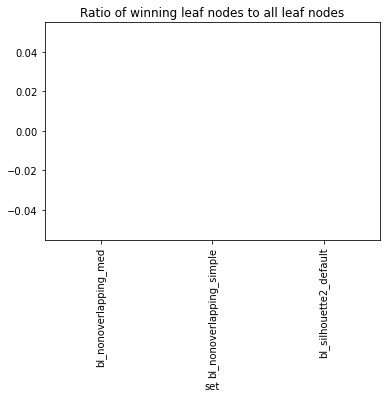

In [14]:
display(df.groupby('set').mean()['outcome_ratio'])
# make barplot with error bars
df.groupby('set').mean()['outcome_ratio'].plot(
    kind='bar', yerr=df.groupby('set')['outcome_ratio'].agg(scipy.stats.sem), title='Ratio of winning leaf nodes to all leaf nodes')


What is the average branching factor?

set
bl_nonoverlapping_med       1.284591
bl_nonoverlapping_simple    3.299600
bl_silhouette2_default      2.350500
Name: avg_branching_factor, dtype: float64

<AxesSubplot:title={'center':'Mean branching factor'}, xlabel='set'>

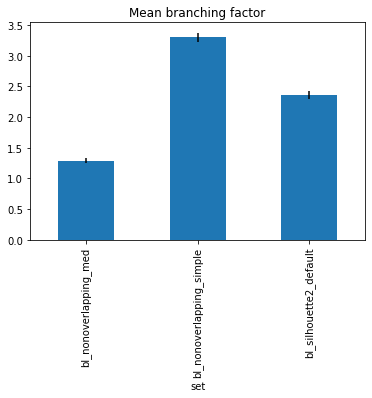

In [15]:
display(df.groupby('set').mean()['avg_branching_factor'])
# make barplot with errorbars
df.groupby('set').mean()['avg_branching_factor'].plot(
    kind='bar', yerr=df.groupby('set')['avg_branching_factor'].agg(scipy.stats.sem), title='Mean branching factor')


What is the average branching factor split up over depth?

In [16]:
def get_depth_branching_factor(depth_dict, depth):
    assert type(depth_dict) == dict
    if depth in depth_dict:
        return np.mean(depth_dict[depth])
    else:
        return np.nan

In [17]:
# let's extract the branching factors according to agent and depth
set_depth_bfs = {}
for set in df['set'].unique():
    bfs = {}
    _df = df[df['set'] == set]
    for i in range(10): # set a reasonable max depth number here
        # get the average branching factor for each depth
        factors = [get_depth_branching_factor(depth_dict, i) for depth_dict in _df['branching_factors']]
        bfs[i] = np.nanmean(factors)
    set_depth_bfs[set] = bfs

/var/folders/2v/0w7xw40n1_9dg_pvjnc9zp380000gn/T/ipykernel_34564/3686302743.py:9: RuntimeWarning: Mean of empty slice
  bfs[i] = np.nanmean(factors)


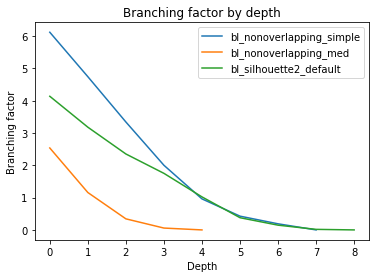

In [18]:
# plot out the branching factors
for set in set_depth_bfs:
    plt.plot(set_depth_bfs[set].keys(), set_depth_bfs[set].values(), label=set)
    plt.legend()
    plt.xlabel('Depth')
    plt.ylabel('Branching factor')
    plt.title('Branching factor by depth')
plt.show()

What is the depth of the random paths?

In [19]:
def get_mean_depth(outcomes):
    return np.mean([o[1] for o in outcomes])

In [20]:
# add mean depth to df
df['mean_depth'] = df['outcomes'].apply(get_mean_depth)

set
bl_nonoverlapping_med       3.055508
bl_nonoverlapping_simple    5.039129
bl_silhouette2_default      5.154591
Name: mean_depth, dtype: float64

<AxesSubplot:title={'center':'Mean depth of leaf nodes'}, xlabel='set'>

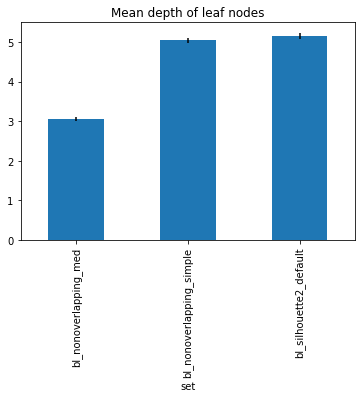

In [21]:
display(df.groupby('set').mean()['mean_depth'])
# make barplot with errorbars
df.groupby('set').mean()['mean_depth'].plot(
    kind='bar', yerr=df.groupby('set')['mean_depth'].agg(scipy.stats.sem), title='Mean depth of leaf nodes')
